In [18]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import proplot as pplt
import cartopy.crs as crs
import cartopy.feature as cfeature
import os
import subprocess as sp
import os
from pathlib import Path 


In [19]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM')) ]
OutvarNames=['tas_nonorm','ps_nonorm','pr_nonorm']
InvarNames=['cres_nonorm','crel_nonorm','netTOAcs_nonorm','cresSurf_nonorm','crelSurf_nonorm','netSurfcs_nonorm']
startD='1959-01-01'
endD='2014-12-31'

path = '/home/jupyter-dipti/work/processed/'
indata = xr.open_dataset(path + 'isosph5.nonorm.ERA5_Exp8_Input.nc')
outdata = xr.open_dataset(path + 'isosph5.nonorm.ERA5_Exp8_Output.nc')

lon = indata.lon
lat = indata.lat

#pred_path='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ERA5_Preds_nonorm_FNO_simul/'
pred_path='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/Predictions/NewRemap_preds'
cmip_path='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/Data_inout_forRemapping/NewRemaping/'

In [28]:
def getAibedoMSE(name,varName):
    #print(name)
    predfiles=pred_path+'FNO_trained_on_'+name+'.nc' #'FNO_trained_on_'+name+'_era5_nonormPred.nc'
    dataPred=xr.open_dataset(predfiles)
    predvar=varName
    preds_data=outdata[predvar].copy(deep=True) ## just for copying coords
    preds_data.values=dataPred[predvar].values
    predBias=preds_data-outdata[predvar]
    predRMSE=(predBias*predBias).mean()
    return (predRMSE)
    

In [29]:
def getCMIPMSE(name,var,month=0,convFac=1.0):
    if(name=='MIROC-ES2L'):
        cmipfiles=cmip_path+'isosph5.denorm_nonorm.'+name+'.historical.r1i1p1f2.Output.nc'
    else: 
        if (name=='ERA5'):
            cmipfiles=cmip_path + 'isosph5.denorm_nonorm.ERA5.Output.nc' #deg2.denorm_nonorm.GFDL-ESM4.historical.r1i1p1f1.Output.nc
        else:
            cmipfiles=cmip_path+'isosph5.denorm_nonorm.'+name+'.historical.r1i1p1f1.Output.nc'
    dataCmip=xr.open_dataset(cmipfiles)
    Cmip_data=dataCmip[var].sel(time=slice(startD,endD))*convFac
    ERA_data=outdata[var].sel(time=slice(startD,endD))*convFac
    bias=Cmip_data.groupby(Cmip_data.time.dt.month).mean(dim='time')-ERA_data.groupby(ERA_data.time.dt.month).mean(dim='time')        
        
    if(month==0):
        biasOut=bias.mean(dim='month')
    else:
        biasOut=bias.sel(month==month)

        
    cmipRMSE=((biasOut*biasOut).mean())
    return (biasOut,cmipRMSE)
 

In [30]:
b,r=getCMIPMSE('CESM2','tas')

dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=14,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    print(name)
    for j,outVar in enumerate(OutvarNames):
        bias,mse=getCMIPMSE(name,outVar,month=0)
        con=axes[i,j].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='coolwarm',levels=np.arange(-.5,.6,.1))
        axes[i,j].colorbar(con, loc='r')
        axes[i,j].set_title(  "  {:0.4f}".format(mse.values))

fig.format(coast=True)
axes.format(
        suptitle='  Bias (with GT ERA5_nonorm) Plots 1979-2014',
        toplabels=('TAS_nonorm', 'PS_nonorm','PR_nonorm'),
        leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


In [26]:
print('test')

test


dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=14,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0)
        if outV=='tas':
            con=axes[i,j].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='coolwarm',levels=np.arange(-5,5.5,.5))
            axes[i,j].set_title(  "  {:0.2f}".format(mse.values))
                
        if outV=='ps':
            con=axes[i,j].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='PRGn',levels=np.arange(-2000,2200,200))
            axes[i,j].set_title(  "  {:0.2f}".format(mse.values))

        if outV=='pr':
            con=axes[i,j].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='BrBg',levels=np.arange(-0.00004,0.000045,.000005))
            axes[i,j].set_title(  "  {:0.2E}".format(mse.values))

        axes[i,j].colorbar(con, loc='r')
        

fig.format(coast=True)
axes.format(
        suptitle='  Bias (with ERA5) Plots 1979-2014',
        toplabels=('TAS', 'PS','PR'),
        leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


FileNotFoundError: [Errno 2] No such file or directory: b'/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/Data_inout_forRemapping/NewRemaping/isosph5.denorm_nonorm.NewRemap_month.historical.r1i1p1f1.Output.nc'

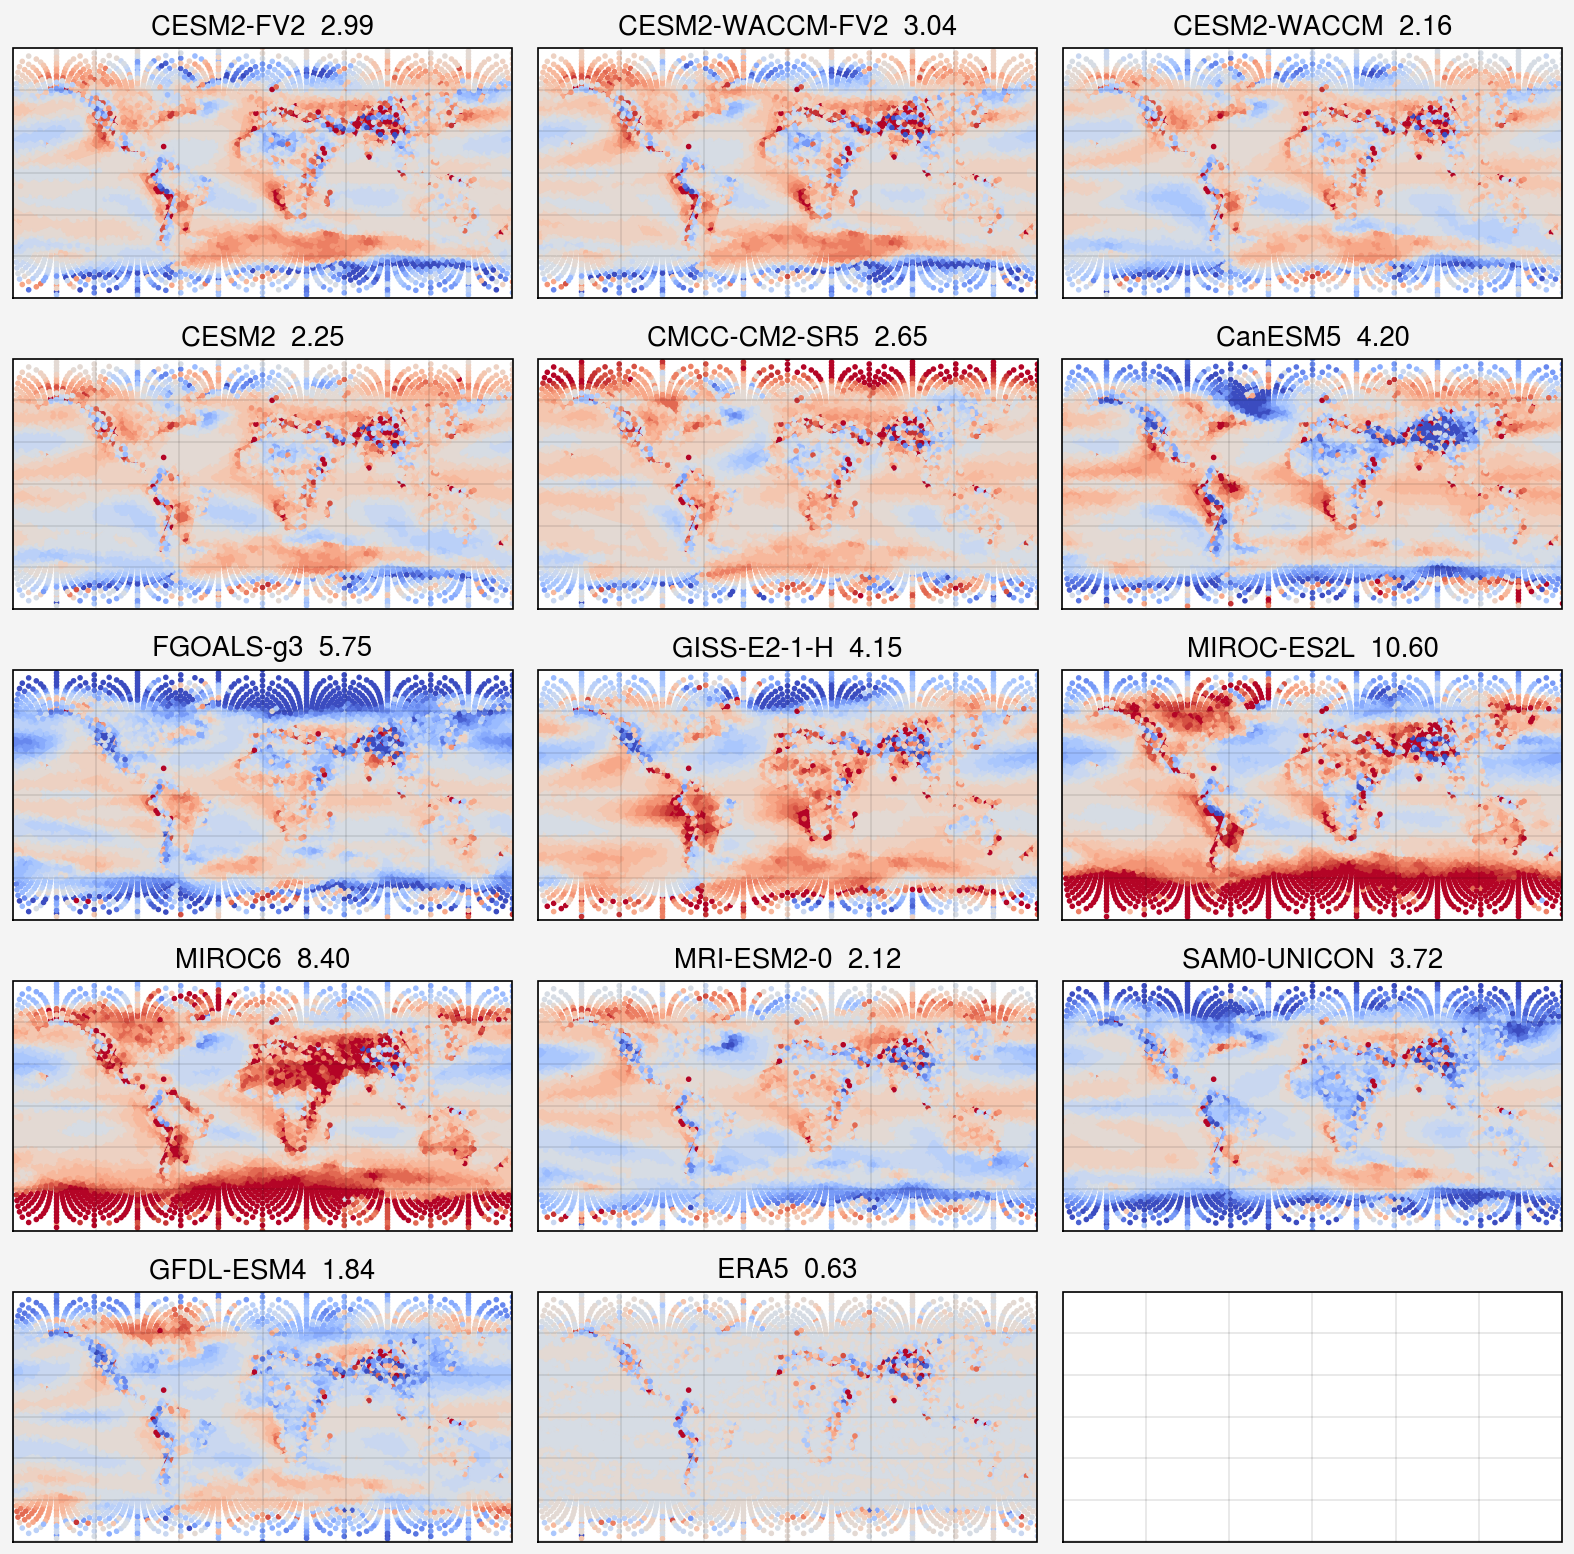

In [27]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=5,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    #print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0)
        if outV=='tas':
            con=axes[i].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='coolwarm',levels=np.arange(-5,5.5,.5))
            axes[i].set_title(  name+"  {:0.2f}".format(mse.values))
                
        

fig.format(coast=True)
fig.colorbar(con)
axes.format(
        suptitle='  Bias (with ERA5) Plots 1959-2014',
        #toplabels=('TAS', 'PS','PR'),
        #leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


In [ ]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=5,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    #print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0,convFac=1.0)
        if outV=='tas':
            con=axes[i].scatter(x=lon,y=lat,c=bias*bias,s=2, transform = crs.PlateCarree()
                              ,extend='max',cmap='YlOrRd',levels=np.arange(0,21,1))
            axes[i].set_title(  name+"  {:0.2f}".format(mse.values))
                
        

fig.format(coast=True)
fig.colorbar(con)
axes.format(
        suptitle='Tas  Squared Bias (with ERA5) Plots 1959-2014',
        #toplabels=('TAS', 'PS','PR'),
        #leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


In [ ]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=5,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    #print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0)
        if outV=='ps':
            con=axes[i].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='PrGN',levels=np.arange(-2000,2200,200))
            axes[i].set_title(  name+"  {:0.2E}".format(mse.values))
                
        

fig.format(coast=True)
fig.colorbar(con)
axes.format(
        suptitle='  Bias (with ERA5) Plots 1959-2014',
        #toplabels=('TAS', 'PS','PR'),
        #leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


In [ ]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=5,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    #print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0,convFac=1e-2)
        if outV=='ps':
            con=axes[i].scatter(x=lon,y=lat,c=bias*bias,s=2, transform = crs.PlateCarree()
                              ,extend='max',cmap='Greys',levels=np.arange(0,550,50))
            axes[i].set_title(  name+"  {:0.2f}".format(mse.values))
                
        

fig.format(coast=True)
fig.colorbar(con)
axes.format(
        suptitle='Ps Squared Bias (with ERA5) Plots 1959-2014',
        #toplabels=('TAS', 'PS','PR'),
        #leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


In [ ]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=5,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    #print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0)
        if outV=='pr':
            con=axes[i].scatter(x=lon,y=lat,c=bias,s=2, transform = crs.PlateCarree()
                              ,extend='both',cmap='BrBg',levels=np.arange(-0.00004,0.000045,.000005))
            axes[i].set_title(  name+"  {:0.2E}".format(mse.values))
                
        

fig.format(coast=True)
fig.colorbar(con)
axes.format(
        suptitle='  Bias (with ERA5) Plots 1959-2014',
        #toplabels=('TAS', 'PS','PR'),
        #leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )


In [ ]:
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('E3SM'))]

fig,axes=pplt.subplots(nrows=5,ncols=3,proj=crs.PlateCarree())
for i,name in enumerate(modelNames):
    #print(name)
    for j,outVar in enumerate(OutvarNames):
        outV=outVar.split('_')[0]
        bias,mse=getCMIPMSE(name,outV,month=0,convFac=8.64e4)
        if outV=='pr':
            con=axes[i].scatter(x=lon,y=lat,c=bias*bias,s=2, transform = crs.PlateCarree()
                              ,extend='max',cmap='YlGnBu',levels=np.arange(0,10.5,.5))
            axes[i].set_title(  name+"  {:0.2f}".format(mse.values))
                
        

fig.format(coast=True)
fig.colorbar(con)
axes.format(
        suptitle='  Pr Squared Bias (with ERA5) Plots 1959-2014',
        #toplabels=('TAS', 'PS','PR'),
        #leftlabels=modelNames#['CESM2','3ESMs','CESM2_MLP','3ESMs_MLP']#modelNames#[modelNames[0:2],modelNames[0:2]
           )
